In [1]:
# from unity_env import init_environment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt


# Unity env executable path
UNITY_EXE_PATH = 'Reacher_Windows_x86_64/Reacher.exe'
# Environment Goal
GOAL = 30.1
# Averaged score
SCORE_AVERAGED = 100
# Let us know the progress each 10 timesteps
PRINT_EVERY = 10
# Number of episode for training
N_EPISODES = 160
# Max Timesteps
MAX_TIMESTEPS = 1000

In [2]:
import random
from actor import Actor
from critic import Critic
import torch
import torch.nn.functional as F
import torch.optim as optim
from replay_buffer import ReplayBuffer

# Replay Buffer Size
BUFFER_SIZE = int(1e6)
# Minibatch Size
BATCH_SIZE = 256 
# Discount Gamma
GAMMA = 0.995 
# Soft Update Value
TAU = 1e-2   
# Learning rates for each NN      
LR_ACTOR = 1e-3 
LR_CRITIC = 1e-3
# Update network every X timesteps
UPDATE_EVERY = 32
# Learn from batch of experiences n_experiences times
N_EXPERIENCES = 16   


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class DDPG():
    """Interacts with and learns from the environment using the DDPG algorithm."""

    def __init__(self, state_size, action_size, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Neural Network (Regular and target)
        self.actor_regular = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_regular.parameters(), lr=LR_ACTOR)

        # Critic Neural Network (Regular and target)
        self.critic_regular = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_regular.parameters(), lr=LR_CRITIC)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
          
        # Ensure that both networks have the same weights
        self.deep_copy(self.actor_target, self.actor_regular)
        self.deep_copy(self.critic_target, self.critic_regular)

    def step(self, states, actions, rewards, next_states, dones, timestep):
        # Save collected experiences
        for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
            self.memory.add(state, action, reward, next_state, done)

        # Learn from our buffer if possible
        if len(self.memory) > BATCH_SIZE and timestep % UPDATE_EVERY == 0:
            for _ in range(N_EXPERIENCES):
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, states):
        states = torch.from_numpy(states).float().to(device)
        
        # Evaluation mode
        # Notify all your layers that you are in eval mode, that way, 
        # Batchnorm or dropout layers will work in eval mode instead of training mode.
        self.actor_regular.eval()
        # torch.no_grad() impacts the autograd engine and deactivate it. 
        # It will reduce memory usage and speed up
        with torch.no_grad():
            actions = self.actor_regular(states).cpu().data.numpy()
        # Enable Training mode
        self.actor_regular.train()

        return actions


    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # Update the critic neural network
        # Get predicted next-state actions
        actions_next = self.actor_target(next_states)
        # Get Q values from target model
        Q_targets_next = self.critic_target(next_states, actions_next)

        # Compute Q targets for current states
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Calculate the critic loss
        Q_expected = self.critic_regular(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)

        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Update the actor neural network
        # Calculate the actor loss
        actions_pred = self.actor_regular(states)
        # Change sign because of the gradient descent
        actor_loss = -self.critic_regular(states, actions_pred).mean()

        # Minimize the loss function
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # Update target network using the soft update approach (slowly updating)
        self.soft_update(self.critic_regular, self.critic_target, TAU)
        self.soft_update(self.actor_regular, self.actor_target, TAU)


    def soft_update(self, local_model, target_model, tau):
        # Update the target network slowly to improve the stability
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau) * target_param.data)

    def deep_copy(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)




cuda:0


In [3]:
from unityagents import UnityEnvironment

def init_environment(executable_path): 
    
    # Init the Reacher Unity Environment
    env = UnityEnvironment(file_name=executable_path)
    # Get the default brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    # Reset the environment
    env_info = env.reset(train_mode=True)[brain_name]
    # Number of agents
    n_agents = len(env_info.agents)
    # Size of each action
    action_size = brain.vector_action_space_size
    
    # Get state space 
    states = env_info.vector_observations
    state_size = states.shape[1]
    
    return env, brain_name, n_agents, state_size, action_size



# Init the reacher environment and get agents, state and action info
env, brain_name, n_agents, state_size, action_size = init_environment(UNITY_EXE_PATH)
agent = DDPG(state_size=state_size, action_size=action_size, random_seed=89)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 10	Average Score: 0.76
Episode 20	Average Score: 1.39
Episode 30	Average Score: 2.67
Episode 40	Average Score: 5.45
Episode 50	Average Score: 9.58
Episode 60	Average Score: 13.66
Episode 70	Average Score: 17.16
Episode 80	Average Score: 19.90
Episode 90	Average Score: 22.05
Episode 100	Average Score: 23.73
Episode 110	Average Score: 27.14

Environment solved in 119 episodes!	Average Score: 30.33


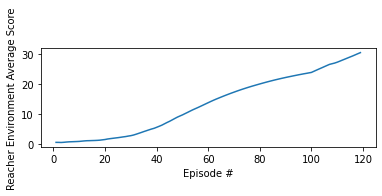

In [4]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" # this avoids the crush of the ipykernel kernel


#  Method for training the agent
def train(n_episodes=N_EPISODES):
    scores_deque = deque(maxlen=SCORE_AVERAGED)
    global_scores = []
    averaged_scores = []
    
    for episode in range(1, N_EPISODES + 1):
        # Get the current states for each agent
        states = env.reset(train_mode=True)[brain_name].vector_observations 
        # Init the score of each agent to zeros
        scores = np.zeros(n_agents)                

        for t in range(MAX_TIMESTEPS):

            # Act according to our policy
            actions = agent.act(states)
            # Send the decided actions to all the agents
            env_info = env.step(actions)[brain_name]        
            # Get next state for each agent
            next_states = env_info.vector_observations     
            # Get rewards obtained from each agent
            rewards = env_info.rewards           
            # Info about if an env is done
            dones = env_info.local_done   
            # Learn from the collected experience
            agent.step(states, actions, rewards, next_states, dones, t)
            # Update current states
            states = next_states   
            # Add the rewards recieved
            scores += rewards    
            
            # Stop the loop if an agent is done               
            if np.any(dones):                          
                break
        
        # Calculate scores and averages
        score = np.mean(scores)
        scores_deque.append(score)
        avg_score = np.mean(scores_deque)
        
        global_scores.append(score)
        averaged_scores.append(avg_score)
                
        if episode % PRINT_EVERY == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_deque)))  
            
        if avg_score >= GOAL:  
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode, avg_score))
            torch.save(agent.actor_regular.state_dict(), 'actor_theta.pth')
            torch.save(agent.critic_regular.state_dict(), 'critic_theta.pth')
            break
            
    return global_scores, averaged_scores

# Train the agent and get the results
scores, averages = train()

# Plot Statistics (Global scores and averaged scores)
plt.subplot(2, 1, 2)
plt.plot(np.arange(1, len(scores) + 1), averages)
plt.ylabel('Reacher Environment Average Score')
plt.xlabel('Episode #')
plt.show()